In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
import os
from getpass import getpass
import bitdotio

# Set bit.io api key
if os.getenv("BITDOTIO_API_KEY"):
    print("bit.io API Key Present in Global Environment")
else:
    os.environ["BITDOTIO_API_KEY"] = getpass("Please enter your API Key")

# Style configuration
sns.set(font_scale=1.5, style='whitegrid')
plt.rcParams["font.family"] = "sans serif"

COLORS = [
    '#0059ff',
    '#fdbd28',
    '#28D9AA',
    '#EE5149',
    '#060F41',
    '#788995',
    '#FF69B4',
    '#7F00FF',
]
sns.set_palette(sns.color_palette(COLORS))
GREY = '#788995'
DARK_GREY = '#060F41'
BLUE = '#0059ff'
DBLUE = '#060F41'
GOLD = '#fdbd28'
GREEN = '#28D9AA'
RED = '#EE5149'
BLACK = '#000000'
WHITE = '#FFFFFF'
LINEWIDTH = 5
LINESPACING = 1.25
FS_SUPTITLE = 30
FS_CAPTION = 24
FS_LABEL = 24
FS_FOOTNOTE = 20

Please enter your API Key ····························


#### Download the dataset from bit.io

In [5]:
sql = '''
SELECT *
FROM "bitdotio/world_gymnastics"."womens_results";
'''

def connect_bitdotio(key):
    '''Get a psycopg2 connection to bit.io'''
    # Connect to bit.io
    b = bitdotio.bitdotio(key)
    # Get psycopg2 connection
    return b.get_connection()  

def pandas_query_bitdotio(key, sql):
    '''Query bit.io and return a pandas dataframe'''
    try:
        # Connect to bit.io
        conn = connect_bitdotio(key)
        # Execute sql
        return pd.read_sql(sql, conn)
    except (Exception) as e:
        print(e)
    finally:
        if conn is not None:
            conn.close()
            
df = pandas_query_bitdotio(os.environ["BITDOTIO_API_KEY"], sql)
df.head()

,year,country,city,rank,gymnast,nationality,vault,uneven_bars,balance_beam,floor,total,event_date
0,2006,DEN,Aarhus,1,Vanessa Ferrari,ITA,14.800,15.825,14.900,15.500,61.025,2006-10-13
1,2006,DEN,Aarhus,2,Jana Bieger,USA,14.725,15.350,15.300,15.375,60.750,2006-10-13
2,2006,DEN,Aarhus,3,Sandra Izbașa,ROM,15.025,14.225,15.475,15.525,60.250,2006-10-13
3,2006,DEN,Aarhus,4,Steliana Nistor,ROM,14.275,15.275,15.800,14.600,59.950,2006-10-13
4,2006,DEN,Aarhus,5,Daria Joura,AUS,14.500,15.100,15.000,15.275,59.875,2006-10-13


#### Standardize scores for top 20 per year

In [6]:
df = df.loc[df['rank'] <= 20]
events = ['vault', 'uneven_bars', 'balance_beam', 'floor']
for event in events:
    df[f'{event}_ss'] = df.groupby('year')[event].transform(lambda x: (x - x.mean()) / x.std())
df.head()

,year,country,city,rank,gymnast,nationality,vault,uneven_bars,balance_beam,floor,total,event_date,vault_ss,uneven_bars_ss,balance_beam_ss,floor_ss
0,2006,DEN,Aarhus,1,Vanessa Ferrari,ITA,14.800,15.825,14.900,15.500,61.025,2006-10-13,0.869933,1.747689,-0.187030,1.424727
1,2006,DEN,Aarhus,2,Jana Bieger,USA,14.725,15.350,15.300,15.375,60.750,2006-10-13,0.707833,0.931814,0.778287,1.197135
2,2006,DEN,Aarhus,3,Sandra Izbașa,ROM,15.025,14.225,15.475,15.525,60.250,2006-10-13,1.356230,-1.000520,1.200613,1.470246
3,2006,DEN,Aarhus,4,Steliana Nistor,ROM,14.275,15.275,15.800,14.600,59.950,2006-10-13,-0.264762,0.802992,1.984933,-0.213937
4,2006,DEN,Aarhus,5,Daria Joura,AUS,14.500,15.100,15.000,15.275,59.875,2006-10-13,0.221536,0.502407,0.054299,1.015061


#### Show event scores and Simone Biles for 2016, 2018, and 2019

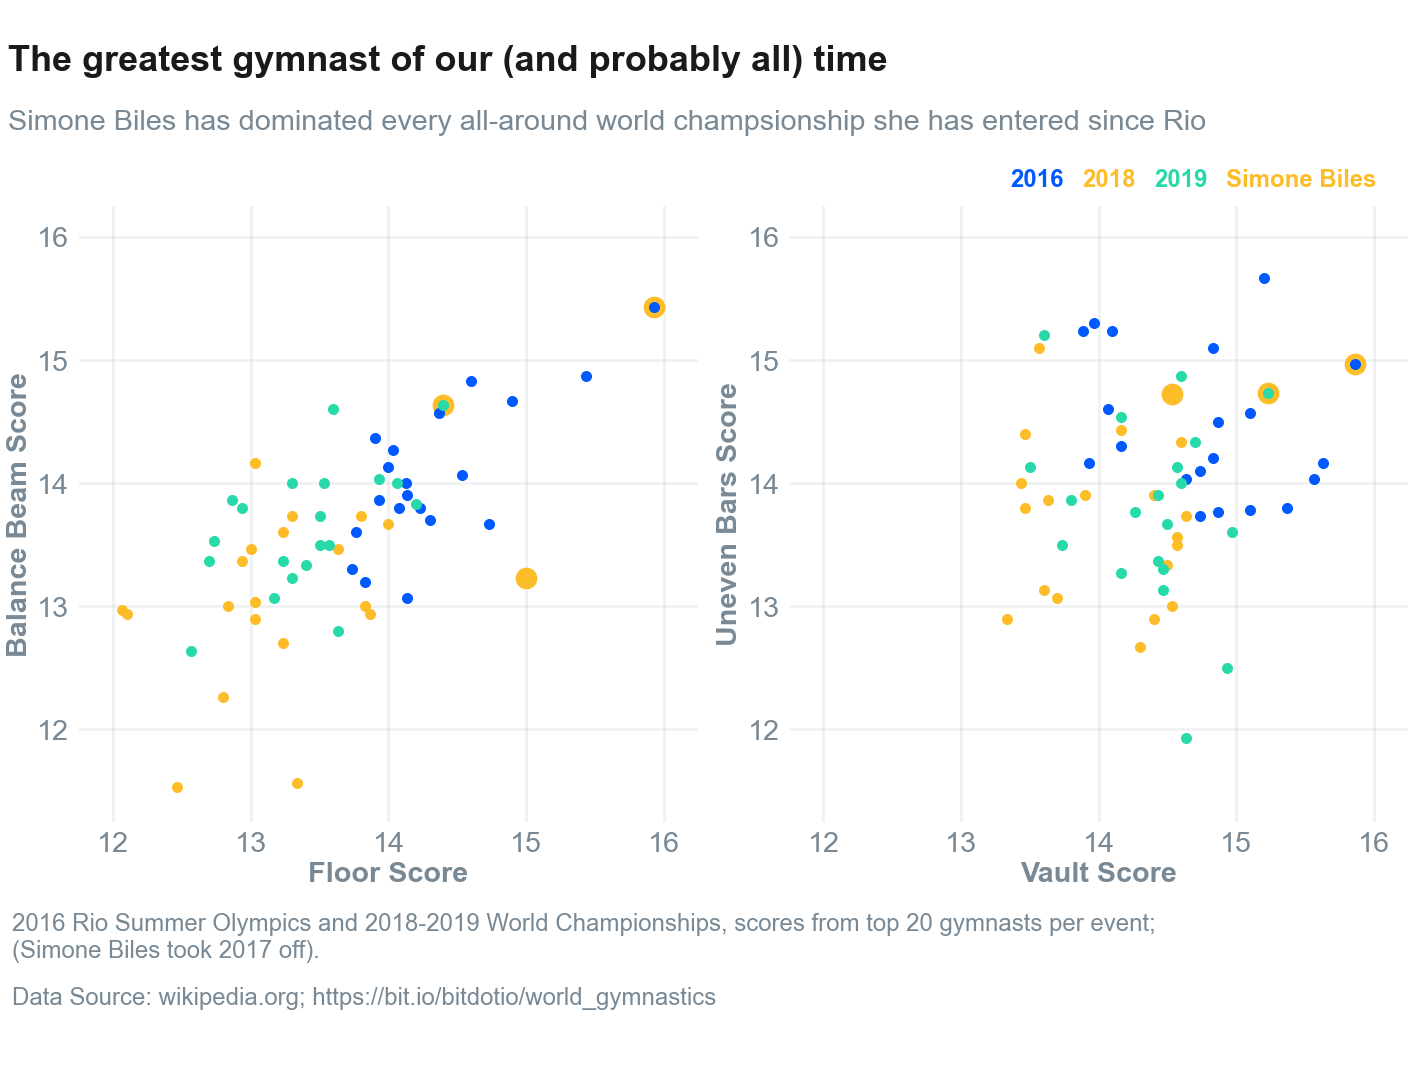

In [7]:
# Paramater for bumping text sizes up and down
fs_scale=1.2

# Get dataframes for last 3 years that Simone has competed
df_recent = df.loc[df['year'].isin([2016, 2018, 2019])]
df_sb = df_recent.loc[df_recent['gymnast'] == 'Simone Biles'].copy()

# Set up plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Map variable names to display names
name_map = {'uneven_bars': 'Uneven Bars Score', 'vault': 'Vault Score', 'balance_beam': 'Balance Beam Score', 'floor': 'Floor Score'}

idx = 0
for x, y in [('floor', 'balance_beam'), ('vault', 'uneven_bars')]:
    ax[idx].scatter(df_sb[x], df_sb[y], alpha=1.0, facecolor=GOLD, edgecolor=GOLD, linewidth=5, s=280)
    for k, year in enumerate(sorted(df_recent['year'].unique())):
        df_temp = df.loc[df['year'] == year].copy()    
        ax[idx].scatter(df_temp[x], df_temp[y], s=100, color=COLORS[k], label=year)
    ax[idx].set(xlim=(11.75,16.25), ylim=(11.25, 16.25))
    ax[idx].tick_params(colors=GREY, labelsize=fs_scale * FS_LABEL, which='both')
    ax[idx].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
    ax[idx].set_xlabel(xlabel=name_map[x], color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
    ax[idx].set_ylabel(ylabel=name_map[y], color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax[idx].spines[spine].set_visible(False)
    idx += 1
fig.tight_layout()
fig.suptitle(' \nThe greatest gymnast of our (and probably all) time', x=0.014, y=1.25, ha='left', fontweight='bold', fontsize=fs_scale * FS_SUPTITLE, color='k')
fig.text(0.014, 1.08, 'Simone Biles has dominated every all-around world champsionship she has entered since Rio', fontsize=fs_scale * FS_CAPTION, color=GREY)
for i, year in enumerate([2016, 2018, 2019]):
    fig.text(0.71 + i * 0.05, 1.0, str(year), fontsize=fs_scale * FS_FOOTNOTE, color=COLORS[i], fontweight='bold')
fig.text(0.86, 1.0, 'Simone Biles', fontsize=fs_scale * FS_FOOTNOTE, color=GOLD, fontweight='bold')
fig.text(x=0.017, y=-0.07, s='2016 Rio Summer Olympics and 2018-2019 World Championships, scores from top 20 gymnasts per event;\n(Simone Biles took 2017 off).', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
fig.text(x=0.017, y=-0.21, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics\n \n', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
plt.show()

#### Show standardized scores

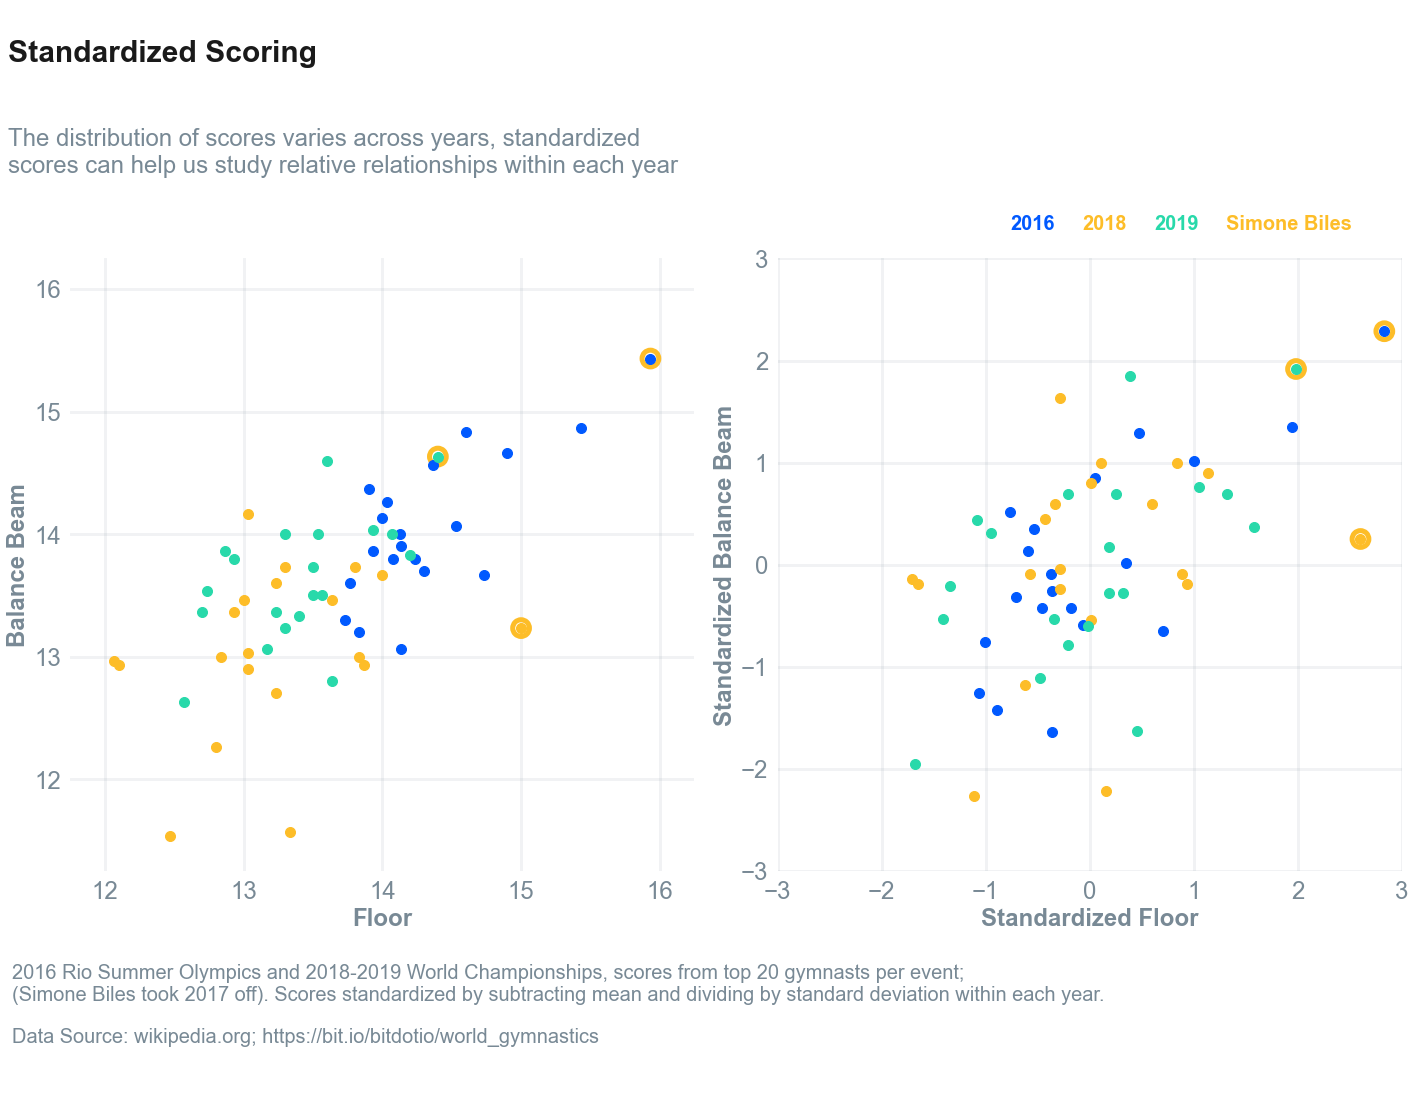

In [9]:
fs_scale = 1
df_recent = df.loc[df['year'].isin([2016, 2018, 2019])]
df_sb = df_recent.loc[df_recent['gymnast'] == 'Simone Biles'].copy()
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
name_map = {'uneven_bars': 'Uneven Bars Score', 'vault': 'Vault Score', 'balance_beam': 'Balance Beam', 'floor': 'Floor', 'floor_ss': 'Standardized Floor', 'balance_beam_ss': 'Standardized Balance Beam'}
df_recent = df.loc[df['year'].isin([2016, 2018, 2019])]
idx = 0
for x, y in [('floor', 'balance_beam'), ('floor_ss', 'balance_beam_ss')]:
    ax[idx].scatter(df_sb[x], df_sb[y], alpha=1.0, facecolor='None', edgecolor=GOLD, linewidth=5, s=280)
    for k, year in enumerate(sorted(df_recent['year'].unique())):
        df_temp = df.loc[df['year'] == year].copy()    
        ax[idx].scatter(df_temp[x], df_temp[y], s=100, color=COLORS[k], label=year)
    ax[idx].tick_params(colors=GREY, labelsize=fs_scale * FS_LABEL, which='both')
    ax[idx].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
    ax[idx].set_xlabel(xlabel=name_map[x], color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
    ax[idx].set_ylabel(ylabel=name_map[y], color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax[idx].spines[spine].set_visible(False)
    idx += 1
ax[0].set(xlim=(11.75,16.25), ylim=(11.25, 16.25))
ax[1].set(xlim=(-3, 3), ylim=(-3, 3))
fig.tight_layout()
fig.suptitle(' \nStandardized Scoring', x=0.014, y=1.31, ha='left', fontweight='bold', fontsize=fs_scale * FS_SUPTITLE, color='k')
fig.text(0.014, 1.08, 'The distribution of scores varies across years, standardized\nscores can help us study relative relationships within each year', fontsize=fs_scale * FS_CAPTION, color=GREY)
for i, year in enumerate([2016, 2018, 2019]):
    fig.text(0.71 + i * 0.05, 1.0, str(year), fontsize=fs_scale * FS_FOOTNOTE, color=COLORS[i], fontweight='bold')
fig.text(0.86, 1.0, 'Simone Biles', fontsize=fs_scale * FS_FOOTNOTE, color=GOLD, fontweight='bold')
fig.text(x=0.017, y=-0.07, s='2016 Rio Summer Olympics and 2018-2019 World Championships, scores from top 20 gymnasts per event;\n(Simone Biles took 2017 off). Scores standardized by subtracting mean and dividing by standard deviation within each year.', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
fig.text(x=0.017, y=-0.19, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics\n \n', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
plt.show()

#### Compute rank correlations

In [10]:
all_corr = []
df_modern = df.loc[df['year'] >= 2010].copy()
events = ['vault', 'uneven_bars', 'balance_beam', 'floor']
for year in df_modern['year'].unique():
    df_temp = df_modern.loc[df_modern['year'] == year].copy()
    for event in events:
        corr = spearmanr(df_temp[event], -1 * df_temp['rank'])[0]
        all_corr.append([year, event, corr])
df_corr = pd.DataFrame(data=all_corr, columns=['year', 'event', 'corr'])
df_corr['event_median'] = df_corr.groupby('event')['corr'].transform(np.median)
df_corr = df_corr.sort_values('event_median')
df_corr.drop_duplicates(subset='event').head()

,year,event,corr,event_median
21,2015,uneven_bars,0.573795,0.578094
16,2014,vault,0.675696,0.593265
22,2015,balance_beam,0.592175,0.621497
35,2018,floor,0.832393,0.660277


#### Show correlations between events

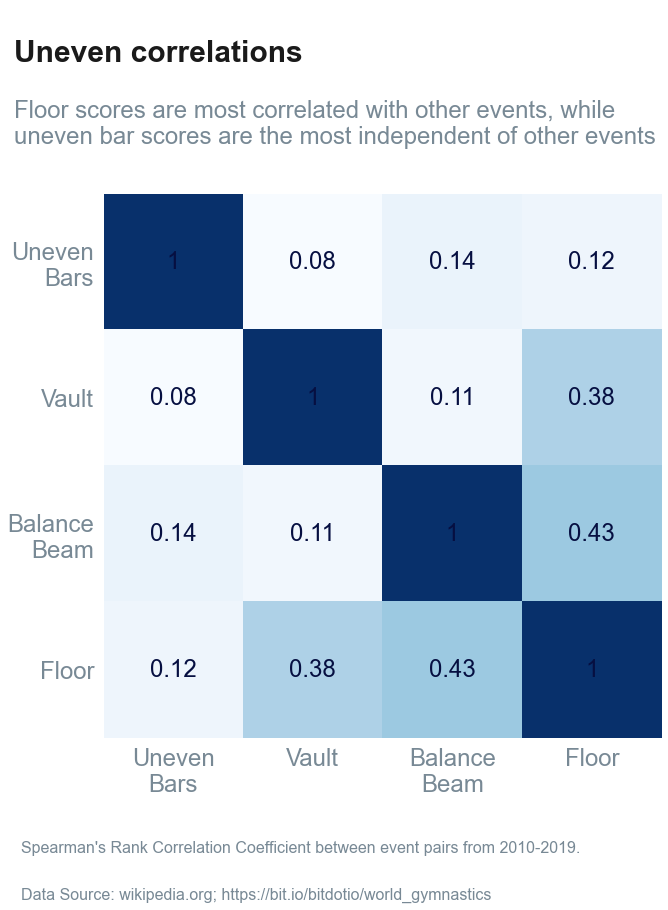

In [13]:
df_events = df_modern[[col for col in df.columns if '_ss' in col]].copy()
df_events.head()
df_corr = df_events.corr(method='spearman')
order = ['uneven_bars_ss', 'vault_ss', 'balance_beam_ss', 'floor_ss']
df_corr = df_corr.loc[order,order].round(2)
# for i in range(5):
#     df_dist.iloc[i, i] = 0
fig, ax = plt.subplots(figsize=(10,10))
# df_dist = df_dist.loc[['User D', 'User E', 'User A', 'User B', 'User C'], ['User D', 'User E', 'User A', 'User B', 'User C']]
sns.heatmap(df_corr, ax=ax, cmap='Blues', cbar=False, annot=True, fmt='.3g', annot_kws={'fontsize': FS_LABEL, 'color': DARK_GREY})
ax.tick_params(colors=GREY, labelsize=FS_LABEL, which='both')
ax.set_xticklabels(['Uneven\nBars', 'Vault', 'Balance\nBeam', 'Floor'], color=GREY, fontsize=FS_LABEL)
ax.set_yticklabels(['Uneven\nBars', 'Vault', 'Balance\nBeam', 'Floor'], color=GREY, fontsize=FS_LABEL)
plt.yticks(rotation=0)
plt.setp(ax.get_xticklabels(), alpha=1.0)
plt.setp(ax.get_yticklabels(), alpha=1.0)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
fig.suptitle('\nUneven correlations', x=0.000, y=1.14, ha='left', fontweight='bold', fontsize=FS_SUPTITLE, color='k')
fig.text(0.00, 0.95, 'Floor scores are most correlated with other events, while\nuneven bar scores are the most independent of other events', fontsize=FS_CAPTION, color=GREY)
fig.text(x=0.01, y=-0.035, s="Spearman's Rank Correlation Coefficient between event pairs from 2010-2019.", ha='left', fontsize=fs_scale * FS_FOOTNOTE - 4, color=GREY)
fig.text(x=0.01, y=-0.1, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics', ha='left', fontsize=fs_scale * FS_FOOTNOTE - 4, color=GREY)
plt.show()

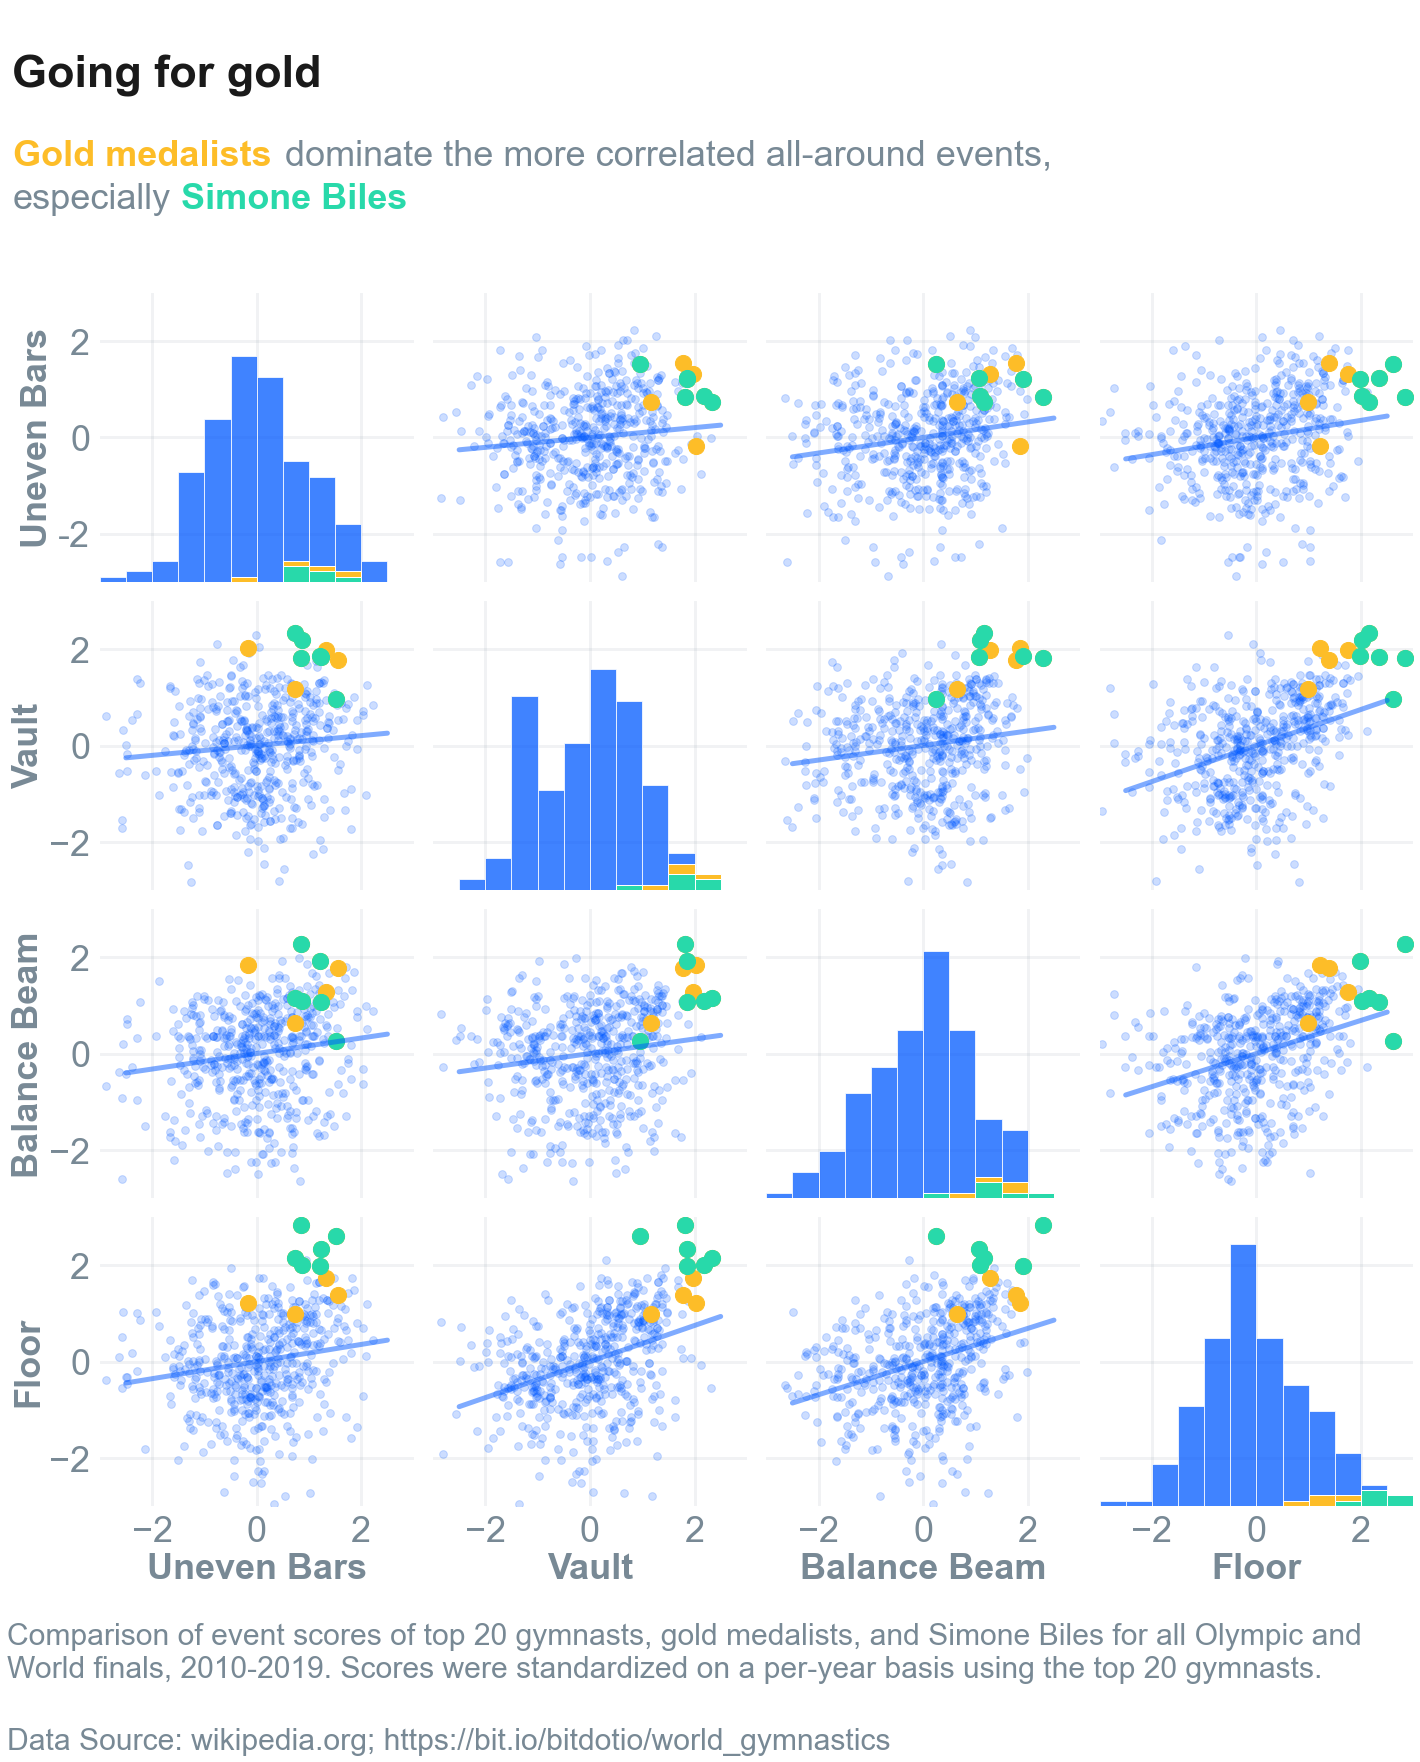

In [14]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
events = ['uneven_bars_ss', 'vault_ss', 'balance_beam_ss', 'floor_ss']
name_map = {'uneven_bars_ss': 'Uneven Bars', 'vault_ss': 'Vault', 'balance_beam_ss': 'Balance Beam', 'floor_ss': 'Floor'}
scol = GREEN
fs_scale = 1.5
for i in range(4):
    for j in range(4):
        x, y = events[j], events[i]
        df_gold = df_modern.loc[df['rank'] == 1]
        df_sb = df_modern.loc[df['gymnast'] == 'Simone Biles'].copy()
        if i == j:
            ax[i][j].hist(df_modern[x], alpha=0.75, bins=np.arange(-3.0,3.5,0.5))
            ax[i][j].hist(df_gold[x], alpha=1.0, bins=np.arange(-3.0,3.5,0.5), color=COLORS[1])
            ax[i][j].hist(df_sb[x], alpha=1.0, bins=np.arange(-3.0,3.5,0.5), color=scol)
            ax[i][j].set(ylim=(0,55))
            ax[i][j].set(yticks=[9.167,27.5,45.833])
            ax[i][j].set(yticklabels=[-2, 0, 2])
        else:
            model = LinearRegression()
            model.fit(df[x].values[:,None], df[y].values)
            xhat = np.arange(-2.5, 3, 0.5)
            yhat = model.predict(xhat[:, None])
            ax[i][j].scatter(df[x], df[y], alpha=0.2, s=60)
            ax[i][j].plot(xhat, yhat, linewidth=LINEWIDTH, color=BLUE, alpha=0.5)
            ax[i][j].scatter(df_gold[x], df_gold[y], alpha=1.0, color=GOLD, s=260)
            ax[i][j].scatter(df_sb[x], df_sb[y], alpha=1.0, s=260, color=scol)
            ax[i][j].set(ylim=(-3,3))
        ax[i][j].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
        ax[i][j].set(xlim=(-3,3))
        ax[i][j].set(xticks=[-2,0,2])
        ax[i][j].tick_params(colors=GREY, labelsize=fs_scale * FS_LABEL, which='both')
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[i][j].spines[spine].set_visible(False)
        if j == 0:
            ax[i][j].set_ylabel(ylabel=name_map[y], color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
        else:
            ax[i][j].axes.yaxis.set_ticklabels([])
        if i == 3:
            ax[i][j].set_xlabel(xlabel=name_map[x], color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
        else:
            ax[i][j].axes.xaxis.set_ticklabels([])
fig.suptitle('\nGoing for gold', x=0.013, y=1.11, ha='left', fontweight='bold', fontsize=fs_scale * FS_SUPTITLE, color='k')

#fig.text(0.0137, 0.97, 'Gold medalists dominate the more correlated all-around events, especially Simone Biles', fontsize=FS_CAPTION, color=GREY)
fig.text(0.014, 1.0, 'Gold medalists', fontsize=fs_scale * FS_CAPTION, color=GOLD, fontweight='bold')
fig.text(0.203, 1.0, 'dominate the more correlated all-around events,', fontsize=fs_scale * FS_CAPTION, color=GREY)
fig.text(0.014, 0.97, 'especially', fontsize=fs_scale * FS_CAPTION, color=GREY)
fig.text(0.131, 0.97, 'Simone Biles', fontsize=fs_scale * FS_CAPTION, color=GREEN, fontweight='bold')
fig.text(x=0.01, y=-0.05, s="Comparison of event scores of top 20 gymnasts, gold medalists, and Simone Biles for all Olympic and\nWorld finals, 2010-2019. Scores were standardized on a per-year basis using the top 20 gymnasts.", ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
fig.text(x=0.01, y=-0.1, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
fig.tight_layout()
plt.show()

#### New scores and new distributions

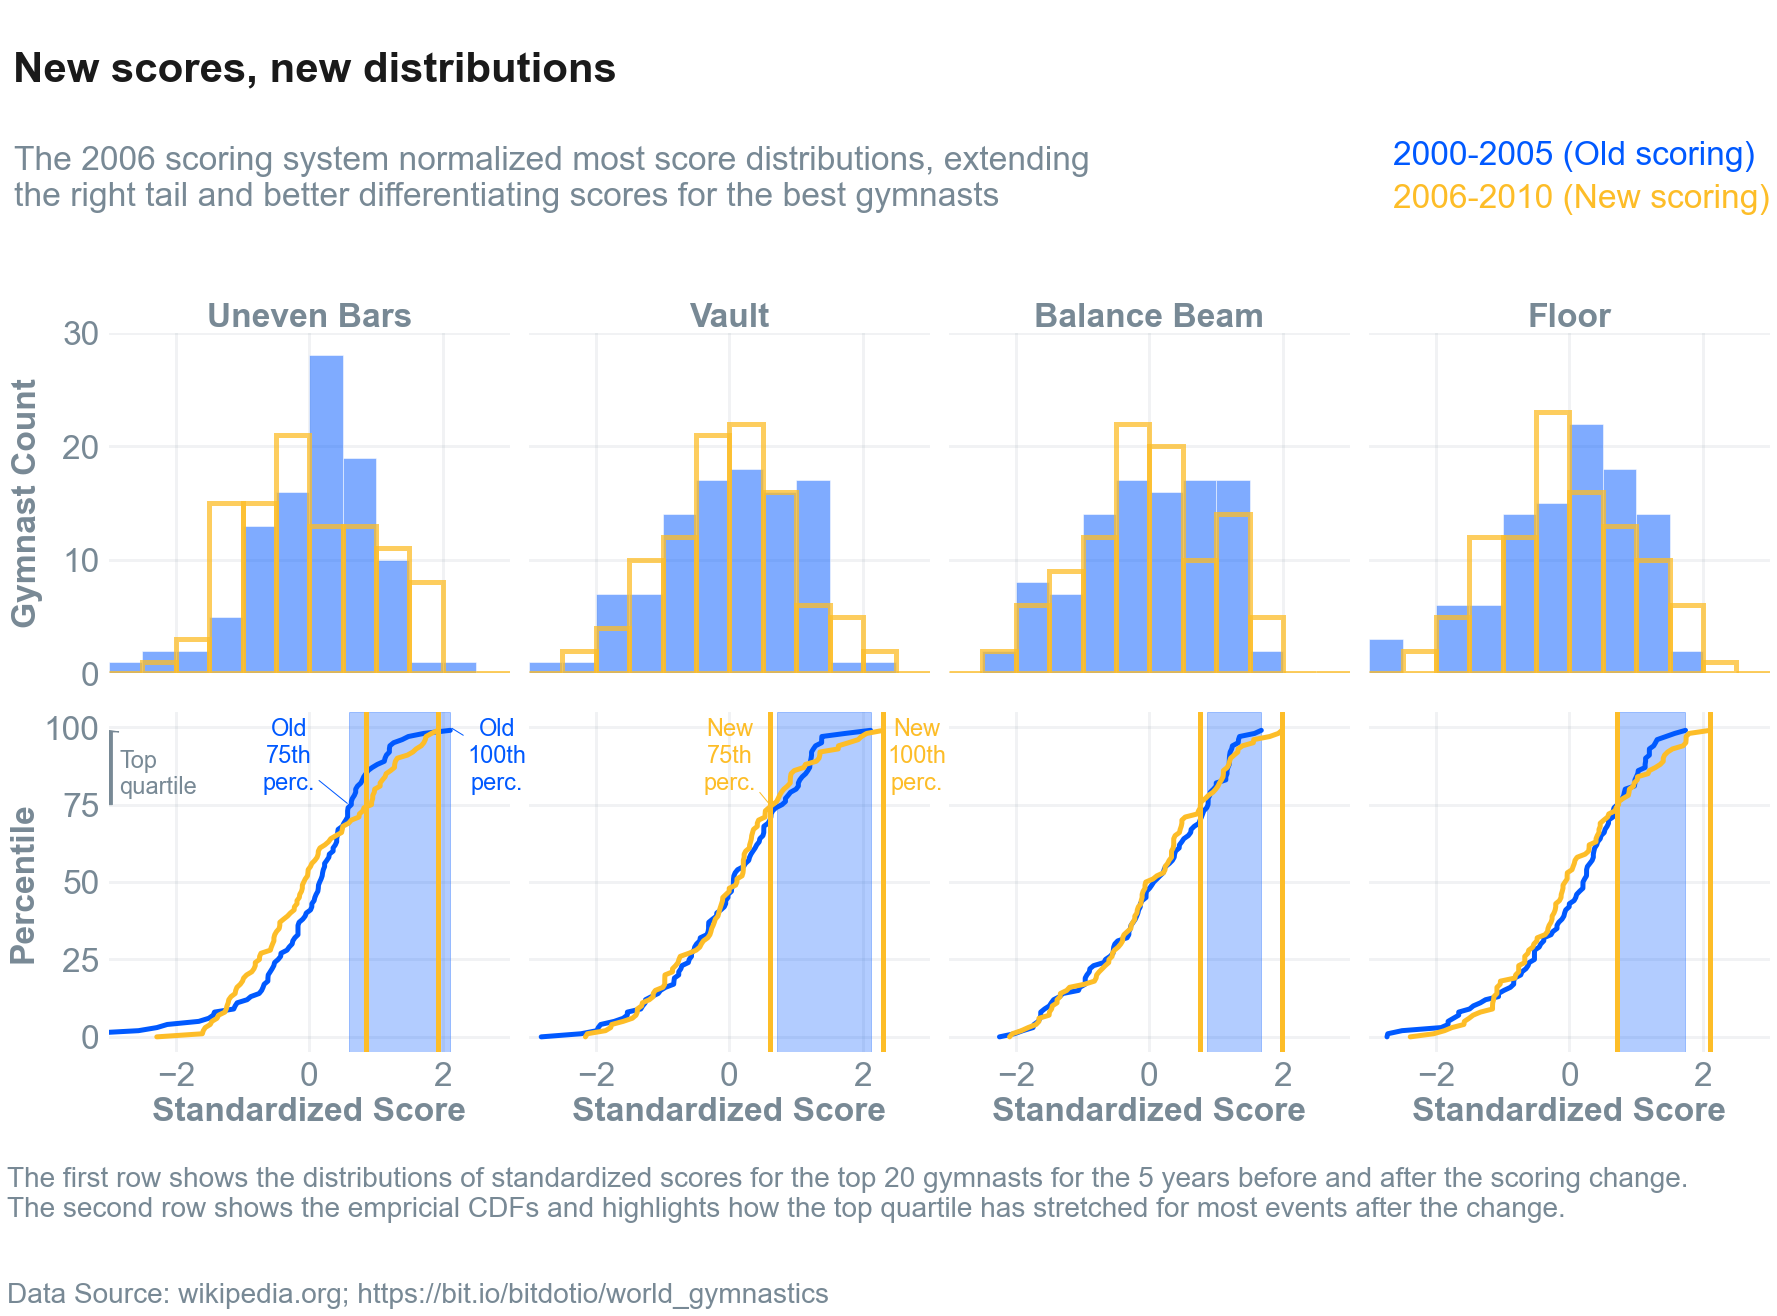

In [19]:
fs_scale = 1.4
df_events_old = df.loc[(df['year'] >= 2000) & (df['year'] <= 2005)][[col for col in df.columns if '_ss' in col]].copy()
df_events_new = df.loc[(df['year'] >= 2006) & (df['year'] <= 2010)][[col for col in df.columns if '_ss' in col]].copy()
df_biles = df.loc[df['gymnast'] == 'Simone Biles']
fig, ax = plt.subplots(2, 4, figsize=(25,12))
events = ['uneven_bars_ss', 'vault_ss', 'balance_beam_ss', 'floor_ss']
name_map = {'uneven_bars_ss': 'Uneven Bars', 'vault_ss': 'Vault', 'balance_beam_ss': 'Balance Beam', 'floor_ss': 'Floor'}

for idx, event in enumerate(events):
    ax[0][idx].hist(df_events_old[event], density=False, alpha=0.5, bins=np.arange(-3.0,3.5,0.5), color=BLUE)
    ax[0][idx].hist(df_events_new[event], alpha=0.75, density=False, bins=np.arange(-3.0,3.5,0.5), fill=False, edgecolor=GOLD, linewidth=LINEWIDTH)
    ax[1][idx].plot(df_events_old[event].sort_values(), 100 * np.arange(df_events_old.shape[0]) / df_events_old.shape[0], color=BLUE, linewidth=LINEWIDTH)
    ax[1][idx].axvspan(df_events_old[event].sort_values().quantile(0.75), df_events_old[event].max(), alpha=0.3, color=BLUE)
    ax[1][idx].plot(df_events_new[event].sort_values(), 100 * np.arange(df_events_new.shape[0]) / df_events_new.shape[0], color=GOLD, linewidth=LINEWIDTH)
    ax[1][idx].axvline(df_events_new[event].sort_values().quantile(0.75), color=GOLD, linewidth=LINEWIDTH)
    ax[1][idx].axvline(df_events_new[event].max(), color=GOLD, linewidth=LINEWIDTH)
    ax[0][idx].set(xlim=(-3,3), ylim=(0,30))
    ax[1][idx].set(xlim=(-3,3), ylim=(-5,105))
    ax[0][idx].set_title(name_map[event], fontsize=fs_scale * FS_LABEL, fontweight='bold', color=GREY)
    ax[0][idx].axes.xaxis.set_ticklabels([])
    for i in range(2):
        if idx != 0:
            ax[i][idx].axes.yaxis.set_ticklabels([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[i][idx].spines[spine].set_visible(False)
        plt.setp(ax[i][idx].get_xticklabels(), alpha=1.0)
        plt.setp(ax[i][idx].get_yticklabels(), alpha=1.0)
        ax[i][idx].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
        ax[i][idx].tick_params(colors=GREY, labelsize=fs_scale * FS_LABEL, which='both')
    ax[1][idx].set_xlabel(xlabel='Standardized Score', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
ax[1][0].arrow(-3, 75, 0, 23.5, color=GREY, width=0.1, alpha=1.0)
ax[1][0].text(-2.85, 78.5, 'Top\nquartile', fontsize=fs_scale * FS_LABEL - 10, ha='left', color=GREY)
ax[0][0].set_ylabel('Gymnast Count', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold', labelpad=19)
ax[1][0].set_ylabel('Percentile', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
fig.tight_layout()
fig.suptitle('\nNew scores, new distributions', x=0.013, y=1.32, ha='left', fontweight='bold', fontsize=fs_scale * FS_SUPTITLE, color='k')
fig.text(0.014, 1.09, 'The 2006 scoring system normalized most score distributions, extending\nthe right tail and better differentiating scores for the best gymnasts', fontsize=fs_scale * FS_CAPTION, color=GREY)
fig.text(0.78, 1.137, '2000-2005 (Old scoring)', fontsize=fs_scale * (FS_CAPTION), color=BLUE)
fig.text(0.78, 1.088, '2006-2010 (New scoring)', fontsize=fs_scale * (FS_CAPTION), color=GOLD)
fig.text(x=0.01, y=-0.08, s='The first row shows the distributions of standardized scores for the top 20 gymnasts for the 5 years before and after the scoring change.\nThe second row shows the empricial CDFs and highlights how the top quartile has stretched for most events after the change.', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
fig.text(x=0.01, y=-0.18, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
ax[1][0].annotate('Old\n75th\nperc.', (df_events_old['uneven_bars_ss'].sort_values().quantile(0.75), 75), (df_events_old['uneven_bars_ss'].sort_values().quantile(0.75) - 0.9, 80), fontsize=fs_scale * FS_LABEL - 10, arrowprops={'arrowstyle':'-', 'color':BLUE}, ha='center', color=BLUE)
ax[1][0].annotate('Old\n100th\nperc.', (df_events_old['uneven_bars_ss'].sort_values().quantile(1), 100), (df_events_old['uneven_bars_ss'].sort_values().quantile(1) + 0.7, 80), fontsize=fs_scale * FS_LABEL - 10, arrowprops={'arrowstyle':'-', 'color':BLUE}, ha='center', color=BLUE)
ax[1][1].annotate('New\n75th\nperc.', (df_events_new['vault_ss'].sort_values().quantile(0.75), 75), (df_events_new['vault_ss'].sort_values().quantile(0.75) - 0.6, 80), fontsize=fs_scale * FS_LABEL - 10, arrowprops={'arrowstyle':'-', 'color':GOLD}, ha='center', color=GOLD)
ax[1][1].annotate('New\n100th\nperc.', (df_events_new['vault_ss'].sort_values().quantile(1), 100), (df_events_new['vault_ss'].sort_values().quantile(1) + 0.5, 80), fontsize=fs_scale * FS_LABEL - 10, arrowprops={'arrowstyle':'-', 'color':GOLD}, ha='center', color=GOLD)
#ax[1][1].annotate('Median %,\n2010-2019', (0.2, 0.578), (0.5, 0.578), fontsize=FS_CAPTION - 4, arrowprops={'arrowstyle':'-', 'color':'k'}, ha='center')
plt.show()

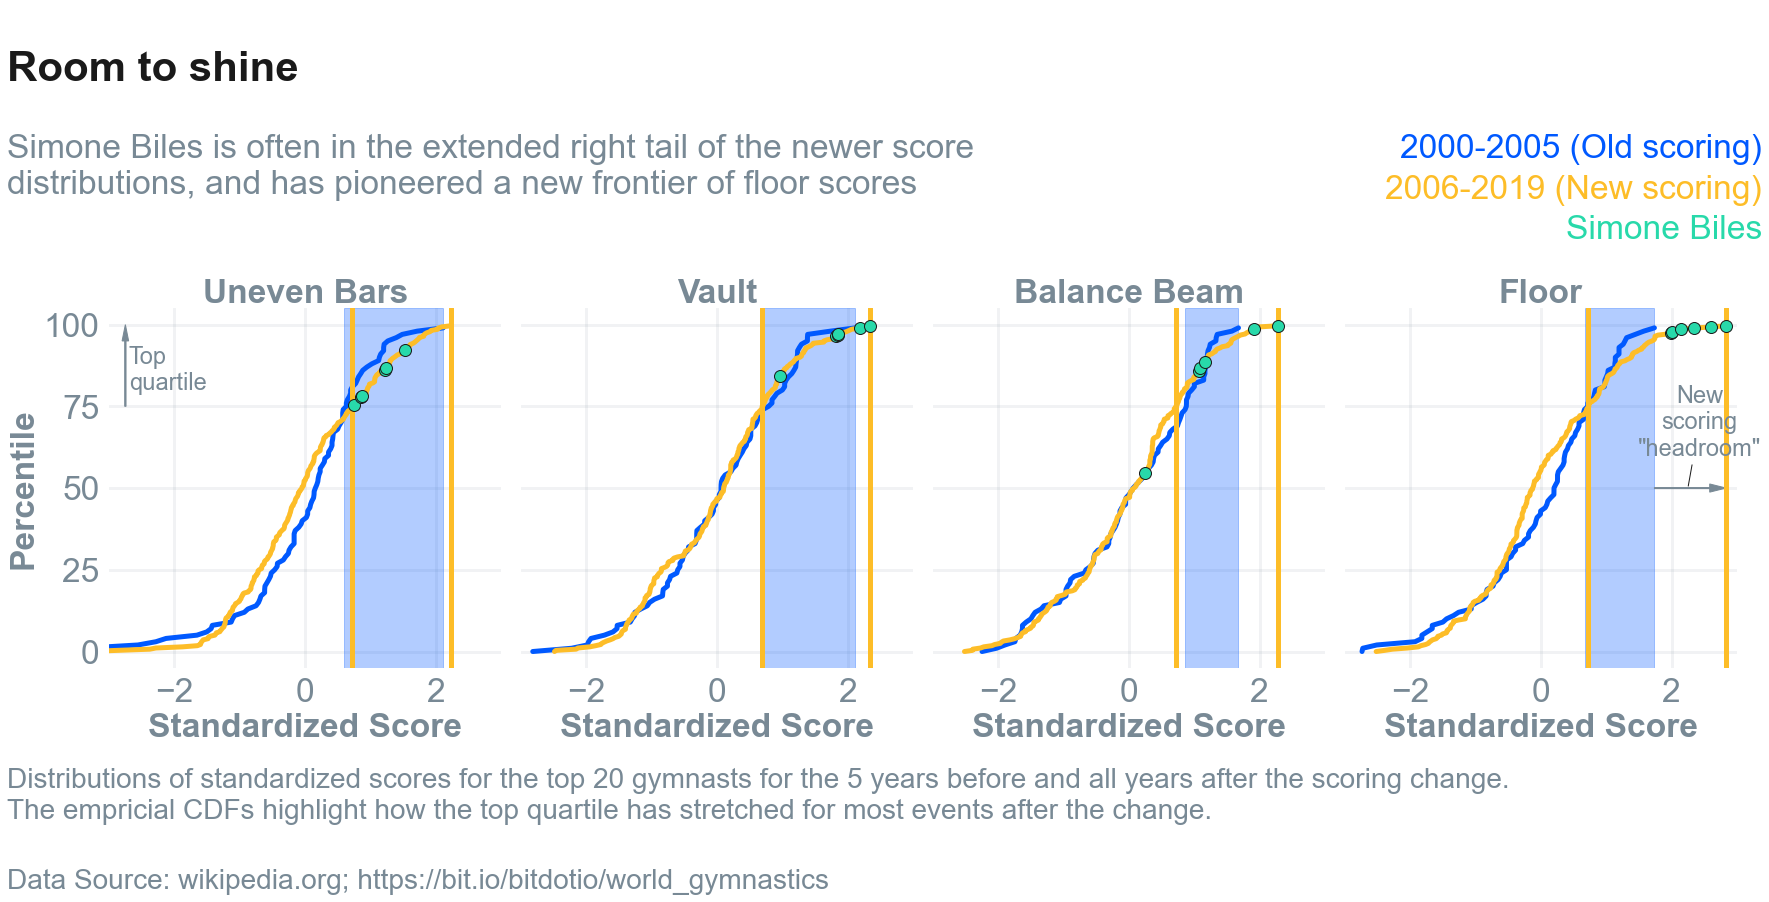

In [20]:
fs_scale = 1.4
df_events_old = df.loc[(df['year'] >= 2000) & (df['year'] <= 2005)][[col for col in df.columns if '_ss' in col]].copy()
df_events_new = df.loc[df['year'] >= 2006].copy()
fig, ax = plt.subplots(1, 4, figsize=(25,7))

for idx, event in enumerate(events):
    ax[idx].plot(df_events_old[event].sort_values(), 100 * np.arange(df_events_old.shape[0]) / df_events_old.shape[0], color=BLUE, linewidth=LINEWIDTH)
    ax[idx].axvspan(df_events_old[event].sort_values().quantile(0.75), df_events_old[event].max(), alpha=0.3, color=BLUE)
    ax[idx].plot(df_events_new[event].sort_values(), 100 * np.arange(df_events_new.shape[0]) / df_events_new.shape[0], color=GOLD, linewidth=LINEWIDTH)
    ax[idx].axvline(df_events_new[event].sort_values().quantile(0.75), color=GOLD, linewidth=LINEWIDTH)
    ax[idx].axvline(df_events_new[event].max(), color=GOLD, linewidth=LINEWIDTH)
    # Plot Simone Biles scores
    df_temp = df_events_new.sort_values(event).copy()
    df_temp['q'] = 100 * np.arange(df_temp.shape[0]) / df_temp.shape[0]
    df_temp = df_temp.loc[df_temp['gymnast'] == 'Simone Biles']
    ax[idx].plot(df_temp[event], df_temp['q'], color=GREEN, linestyle='', marker='o', markersize=12, markeredgecolor='k')
    ax[idx].set(xlim=(-3,3), ylim=(0,25))
    ax[idx].set(xlim=(-3,3), ylim=(-5,105))
    ax[idx].set_title(name_map[event], fontsize=fs_scale * FS_LABEL, fontweight='bold', color=GREY)
    for spine in ['top', 'right', 'left', 'bottom']:
        ax[idx].spines[spine].set_visible(False)
    ax[idx].grid(b=True, color=GREY, alpha=0.1, linewidth=3)
    ax[idx].tick_params(colors=GREY, labelsize=fs_scale * FS_LABEL, which='both')
    ax[idx].set_xlabel(xlabel='Standardized Score', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
    if idx != 0:
        ax[idx].axes.yaxis.set_ticklabels([])
    else:
        ax[idx].set_ylabel(ylabel='Percentile', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
ax[0].arrow(-3 + 0.25, 75, 0, 25 - 5, color=GREY, width=0.02, alpha=1.0, head_length=5, head_width=0.1)
ax[3].arrow(df_events_old['floor_ss'].max(), 50, (df_events_new['floor_ss'].max() - df_events_old['floor_ss'].max() - 0.25), 0, color=GREY, width=0.3, alpha=1.0, head_length=0.25, head_width=2.5)
ax[0].text(-2.7, 80, 'Top\nquartile', fontsize=fs_scale * FS_LABEL - 10, ha='left', color=GREY)
ax[3].annotate('New\nscoring\n"headroom"', (2.25, 50), (2.43, 60), fontsize=fs_scale * FS_LABEL - 10, color=GREY, arrowprops={'arrowstyle':'-', 'color':'k'}, ha='center')
#ax[3].text(2.25, 27, 'New\nscoring\n"headroom"', fontsize=fs_scale * FS_LABEL - 10, ha='center', color=GREY)
fig.tight_layout()
fig.suptitle('\nRoom to shine', x=0.01, y=1.5, ha='left', fontweight='bold', fontsize=fs_scale * FS_SUPTITLE, color='k')
fig.text(0.010, 1.13, 'Simone Biles is often in the extended right tail of the newer score\ndistributions, and has pioneered a new frontier of floor scores', fontsize=fs_scale * FS_CAPTION, color=GREY)
fig.text(0.985, 1.20, '2000-2005 (Old scoring)', fontsize=fs_scale * FS_CAPTION, color=BLUE, ha='right')
fig.text(0.985, 1.12, '2006-2019 (New scoring)', fontsize=fs_scale * FS_CAPTION, color=GOLD, ha='right')
fig.text(0.985, 1.04, 'Simone Biles', fontsize=fs_scale * FS_CAPTION, color=GREEN, ha='right')
fig.text(x=0.01, y=-0.11, s='Distributions of standardized scores for the top 20 gymnasts for the 5 years before and all years after the scoring change.\nThe empricial CDFs highlight how the top quartile has stretched for most events after the change.', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
fig.text(x=0.01, y=-0.25, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics', ha='left', fontsize=fs_scale * FS_FOOTNOTE, color=GREY)
plt.show()

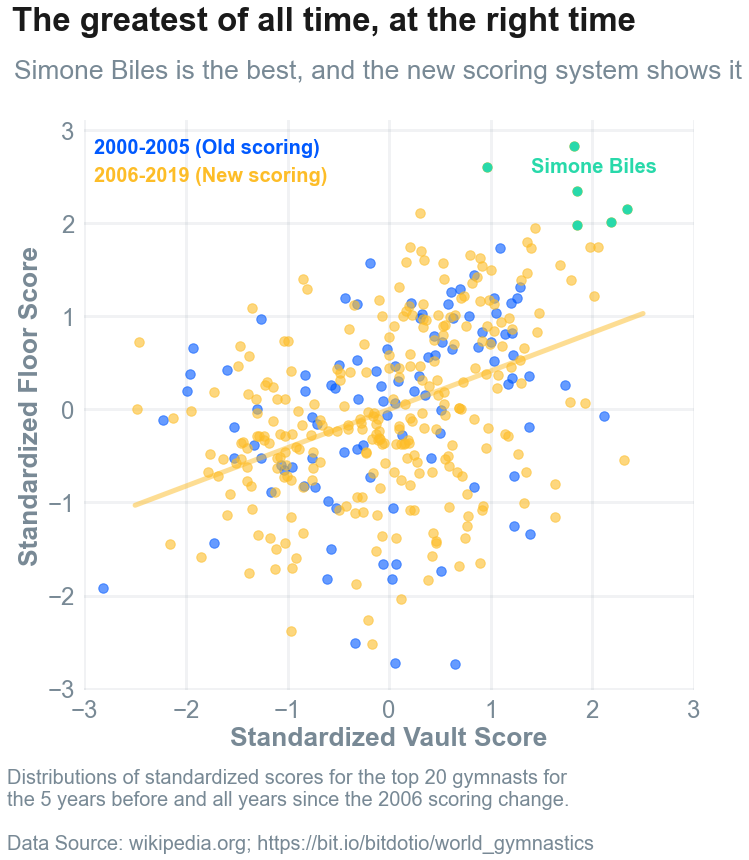

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
fs_scale = 1.1
df_sb = df_events_new.loc[df_events_new['gymnast'] == 'Simone Biles']
#ax.scatter(df_events_old['vault_ss'], df_events_old['floor_ss'], facecolors='white', edgecolors=BLUE, alpha=0.6, s=90, linewidth=2)
ax.scatter(df_events_old['vault_ss'], df_events_old['floor_ss'], color=BLUE, alpha=0.6, s=90)
#ax.scatter(df_events_new['vault_ss'], df_events_new['floor_ss'], facecolors='white', edgecolors=GOLD, alpha=0.6, s=90, linewidth=2)
ax.scatter(df_events_new['vault_ss'], df_events_new['floor_ss'], color=GOLD, alpha=0.6, s=90)
ax.scatter(df_sb['vault_ss'], df_sb['floor_ss'], color=GREEN, s=80)
for df_temp, color in zip([df_events_new], [GOLD]):
    model = LinearRegression()
    model.fit(df_temp['vault_ss'].values[:,None], df_temp['floor_ss'].values)
    xhat = np.arange(-2.5, 3, 0.5)
    yhat = model.predict(xhat[:, None])
    ax.plot(xhat, yhat, linewidth=LINEWIDTH, color=color, alpha=0.5)
ax.set(xlim=(-3,3))
ax.tick_params(colors=GREY, labelsize=FS_LABEL, which='both')
ax.grid(b=True, color=GREY, alpha=0.1, linewidth=3)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.set_xlabel(xlabel='Standardized Vault Score', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
ax.set_ylabel(ylabel='Standardized Floor Score', color=GREY, fontsize=fs_scale * FS_LABEL, fontweight='bold')
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
fig.suptitle('The greatest of all time, at the right time', x=0.016, y=1.06, ha='left', fontweight='bold', fontsize=fs_scale * FS_SUPTITLE, color='k')
fig.text(0.02, 0.96, 'Simone Biles is the best, and the new scoring system shows it', fontsize=fs_scale * FS_CAPTION, color=GREY)
#fig.text(0.0137, 0.97, 'Gold medalists dominate the more correlated all-around events, especially Simone Biles', fontsize=FS_CAPTION, color=GREY)
ax.text(-2.9, 2.75, '2000-2005 (Old scoring)', fontsize=FS_CAPTION - 4, color=BLUE, fontweight='bold')
ax.text(-2.9, 2.45, '2006-2019 (New scoring)', fontsize=FS_CAPTION - 4, color=GOLD, fontweight='bold')
ax.text(1.4, 2.55, 'Simone Biles', fontsize=FS_CAPTION - 4, color=GREEN, fontweight='bold')
#fig.text(x=0.032, y=-0.04, s='Source: wikipedia.org\nData: bit.io/bitdotio/world_gymnastics', ha='left', fontsize=FS_FOOTNOTE, color=GREY)
fig.text(x=0.01, y=-0.05, s='Distributions of standardized scores for the top 20 gymnasts for\nthe 5 years before and all years since the 2006 scoring change.', ha='left', fontsize=FS_FOOTNOTE, color=GREY)
fig.text(x=0.01, y=-0.11, s='Data Source: wikipedia.org; https://bit.io/bitdotio/world_gymnastics', ha='left', fontsize=FS_FOOTNOTE, color=GREY)
fig.tight_layout()
plt.show()